In [ ]:
from util.utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model
import torch
from ultralytics import YOLO
from PIL import Image

# Auto-detect device - use CUDA only if available and compiled with CUDA
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

model_path='weights/icon_detect/model.pt'

som_model = get_yolo_model(model_path)

som_model.to(device)
print('model to {}'.format(device))

In [2]:
%pip list | findstr paddleocr

paddleocr                 3.3.0
Note: you may need to restart the kernel to use updated packages.


In [3]:
# two choices for caption model: fine-tuned blip2 or florence2
import importlib
# import util.utils
# importlib.reload(utils)
from util.utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model
#caption_model_processor = get_caption_model_processor(model_name="florence2", model_name_or_path="weights/icon_caption_florence", device=device)
caption_model_processor = get_caption_model_processor(model_name="florence2", model_name_or_path="microsoft/Florence-2-base")


`torch_dtype` is deprecated! Use `dtype` instead!


In [4]:
som_model.device, type(som_model) 

(device(type='cuda', index=0), ultralytics.models.yolo.model.YOLO)

In [ ]:
# reload utils
import importlib
import util.utils
importlib.reload(util.utils)
# from utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model

image_path = 'imgs/google_page.png'
image_path = 'imgs/windows_home.png'
# image_path = 'imgs/windows_multitab.png'
# image_path = 'imgs/omni3.jpg'
# image_path = 'imgs/ios.png'
image_path = 'imgs/word.png'
# image_path = 'imgs/excel2.png'

image = Image.open(image_path)
image_rgb = image.convert('RGB')
print('image size:', image.size)

box_overlay_ratio = max(image.size) / 3200
draw_bbox_config = {
    'text_scale': 0.8 * box_overlay_ratio,
    'text_thickness': max(int(2 * box_overlay_ratio), 1),
    'text_padding': max(int(3 * box_overlay_ratio), 1),
    'thickness': max(int(3 * box_overlay_ratio), 1),
}
BOX_TRESHOLD = 0.05

import time
start = time.time()
ocr_bbox_rslt, is_goal_filtered = check_ocr_box(image_path, display_img = False, output_bb_format='xyxy', goal_filtering=None, easyocr_args={'paragraph': False, 'text_threshold':0.9}, use_paddleocr=True)
text, ocr_bbox = ocr_bbox_rslt
cur_time_ocr = time.time() 

dino_labled_img, label_coordinates, parsed_content_list = get_som_labeled_img(image_path, som_model, BOX_TRESHOLD = BOX_TRESHOLD, output_coord_in_ratio=True, ocr_bbox=ocr_bbox,draw_bbox_config=draw_bbox_config, caption_model_processor=caption_model_processor, ocr_text=text,use_local_semantics=True, iou_threshold=0.7, scale_img=False, batch_size=128)
cur_time_caption = time.time() 


# torch checks

In [8]:
# check if gpu is available for cuda
import torch
print('CUDA available:', torch.cuda.is_available())
!nvidia-smi

CUDA available: True
Mon Oct 27 13:09:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 577.00                 Driver Version: 577.00         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
| 30%   35C    P8             15W /  200W |    7694MiB /   8192MiB |      3%      Default |
|                                         |                        |                  N/A |
+--------------------------

<Figure size 1500x1500 with 0 Axes>

(0.0, 1.0, 0.0, 1.0)

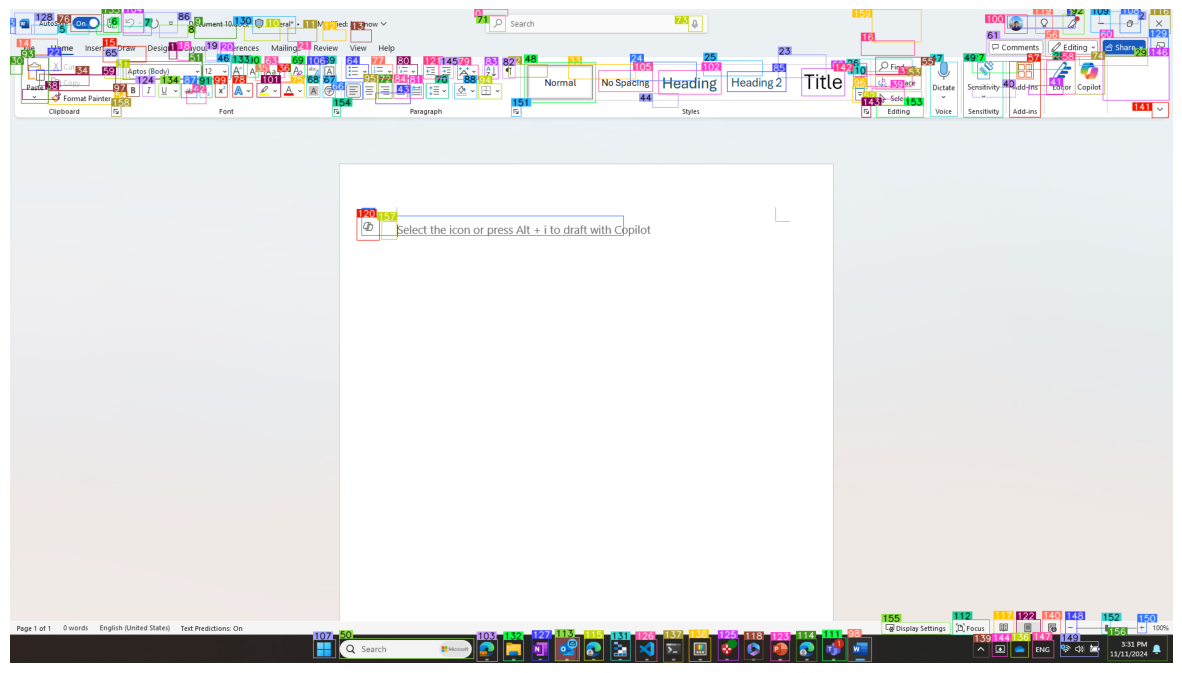

In [9]:
# plot dino_labled_img it is in base64
import base64
import matplotlib.pyplot as plt
import io
plt.figure(figsize=(15,15))

image = Image.open(io.BytesIO(base64.b64decode(dino_labled_img)))
plt.axis('off')

plt.imshow(image)
# print(len(parsed_content_list))


In [10]:
import pandas as pd
df = pd.DataFrame(parsed_content_list)
df['ID'] = range(len(df))

df

,type,bbox,interactivity,content,source,ID
0,text,"[0.40594059228897095, 0.0, 0.42782700061798096...",False,Search,box_ocr_content_ocr,0
1,text,"[0.8572173118591309, 0.010194624774158001, 0.9...",False,Comments,box_ocr_content_ocr,1
2,text,"[0.9364252090454102, 0.003707136260345578, 0.9...",False,Editing,box_ocr_content_ocr,2
3,text,"[0.0, 0.025949953123927116, 0.0046899425797164...",False,e,box_ocr_content_ocr,3
4,text,"[0.018238665536046028, 0.024096384644508362, 0...",False,Home,box_ocr_content_ocr,4
...,...,...,...,...,...,...
155,icon,"[0.7498583793640137, 0.9372037649154663, 0.808...",True,a photo of a person in a room with a lot of wi...,box_yolo_content_yolo,155
156,icon,"[0.9438562989234924, 0.9580971002578735, 0.995...",True,a picture of a person with a clock on their head,box_yolo_content_yolo,156
157,icon,"[0.3195081055164337, 0.32292044162750244, 0.33...",True,a black and white photo of a woman's face,box_yolo_content_yolo,157
158,icon,"[0.08737809956073761, 0.14849460124969482, 0.0...",True,a black and white photo of a woman's face,box_yolo_content_yolo,158


In [11]:
parsed_content_list

[{'type': 'text',
  'bbox': [0.40594059228897095,
   0.0,
   0.42782700061798096,
   0.010194624774158001],
  'interactivity': False,
  'content': 'Search',
  'source': 'box_ocr_content_ocr'},
 {'type': 'text',
  'bbox': [0.8572173118591309,
   0.010194624774158001,
   0.9155810475349426,
   0.028730304911732674],
  'interactivity': False,
  'content': 'Comments',
  'source': 'box_ocr_content_ocr'},
 {'type': 'text',
  'bbox': [0.9364252090454102,
   0.003707136260345578,
   0.969775915145874,
   0.022242818027734756],
  'interactivity': False,
  'content': 'Editing',
  'source': 'box_ocr_content_ocr'},
 {'type': 'text',
  'bbox': [0.0,
   0.025949953123927116,
   0.004689942579716444,
   0.037071362137794495],
  'interactivity': False,
  'content': 'e',
  'source': 'box_ocr_content_ocr'},
 {'type': 'text',
  'bbox': [0.018238665536046028,
   0.024096384644508362,
   0.04064616933465004,
   0.03799814730882645],
  'interactivity': False,
  'content': 'Home',
  'source': 'box_ocr_conten